# Init

In [1]:

import sys
sys.path.insert(0, '..')

import multiprocessing as mp
from database.dataset import INBreast_Dataset
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show2, simple_im_show
from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np

from skimage import restoration



In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=2.0, #max 315 pixels area
    extract_patches=False,
    extract_patches_method='all',  # 'centered'
    patch_size=256,
    stride=256,
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    lesion_types=['calcification', 'cluster'],
    return_indexes_in_mask=True)


# Magic

In [3]:
def min_max_norm(img):
        return (img - img.min())/(img.max() - img.min())
def to_uint8(img):
        return (255*min_max_norm(img)).astype(np.uint8)
def sobel_gradient(img):
        grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        grad = np.sqrt(grad_x**2 + grad_y**2)
        return grad


In [15]:
idx = 81
image_mask = db[idx]['lesion_mask']
image = db[idx]['img']
norm_image = min_max_norm(image.astype(np.float32))
image_id = db.df.iloc[idx].img_id
true_bboxes = db[idx]['lesion_bboxes']

In [16]:
bbox_img = plot_bboxes_over_image(image, [true_bboxes], [(0, 255, 0)], ['rect'])
cv2.imwrite('image_bbox.tiff', bbox_img)

True

### Reconstruction by dialation

In [17]:
def reconstruction_by_dialation(image, rect_size=3, circle_size=20):
    """Reconstructs image using grayscale dialation

    Args:
        image (np.ndarray): Image arre of type float or np.uint8
        rect_size (int, optional): Size of the SE used for geodesic reconstruction. Defaults to 3.
        circle_size (int, optional): Size of the SE used for creating a marker image. Defaults to 20.
    """
    rect_SE = cv2.getStructuringElement(cv2.MORPH_RECT, (rect_size, rect_size))
    circle_SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (circle_size, circle_size))

    marker = cv2.morphologyEx(image, cv2.MORPH_OPEN, circle_SE)
    mask = image.copy()

    marker_cur = marker.copy()

    while(True):
        marker_prev = marker_cur.copy()
        marker_cur = cv2.min(cv2.dilate(marker_prev, rect_SE), mask) 
        if np.all(marker_prev==marker_cur):
            break
    return mask - marker_cur

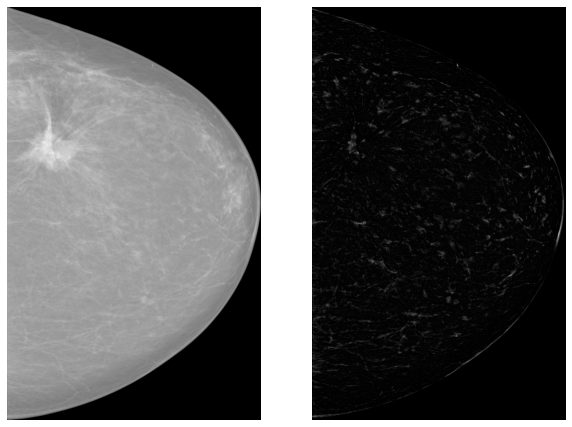

In [18]:
# rbd_image = reconstruction_by_dialation(norm_image) # takes around 30s
# cv2.imwrite('rbd_image.tiff', rbd_image)

rbd_path = Path('/home/vzalevskyi/projects/calc-det/data/recounstructed_by_dialation_img/')


rbd_image = cv2.imread(str(rbd_path/f'{image_id}.tiff'), cv2.IMREAD_ANYDEPTH)

simple_im_show2(norm_image, rbd_image)

### Breast boundary erosion

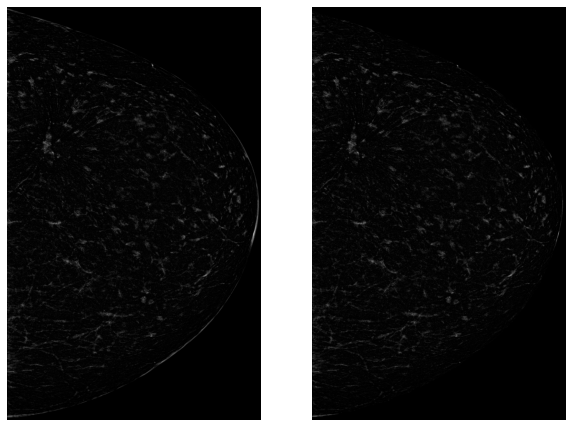

In [19]:
erosion_size = 5
erosion_iter = 10

breast_mask = (image != 0).astype(np.uint8)
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT,
                                                (erosion_size, erosion_size))
breast_boundary_mask = cv2.erode(breast_mask, structuring_element,
                                    iterations=erosion_iter)
rbd_image_no_bbound = rbd_image.copy()
rbd_image_no_bbound[breast_boundary_mask == 0] = 0

simple_im_show2(rbd_image, rbd_image_no_bbound)

### First thresholding

quantile 0.97 - threshold 0.050265610218048096


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

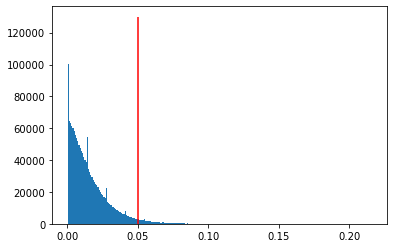

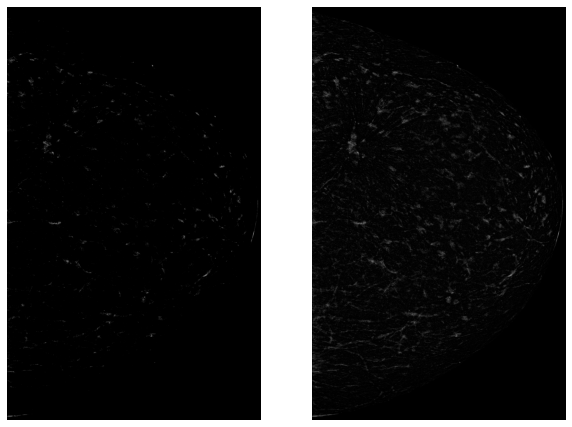

In [20]:
quant = 0.97

trheshold = np.quantile(rbd_image_no_bbound[rbd_image_no_bbound!=0].ravel(), q=quant)
print(f'quantile {quant} - threshold {trheshold}')
plt.hist(rbd_image_no_bbound[rbd_image_no_bbound!=0].ravel(), bins=256)
plt.vlines(trheshold, ymin=0, ymax=130000, colors='red')
plt.show()


thr1_rbd = rbd_image_no_bbound.copy()
thr1_rbd[thr1_rbd <= trheshold] = 0

simple_im_show2(thr1_rbd, rbd_image_no_bbound)

In [21]:
cv2.imwrite('orig_quant97_reconstr_by_dialation.tiff', thr1_rbd)


True

### Sobel Gradiend

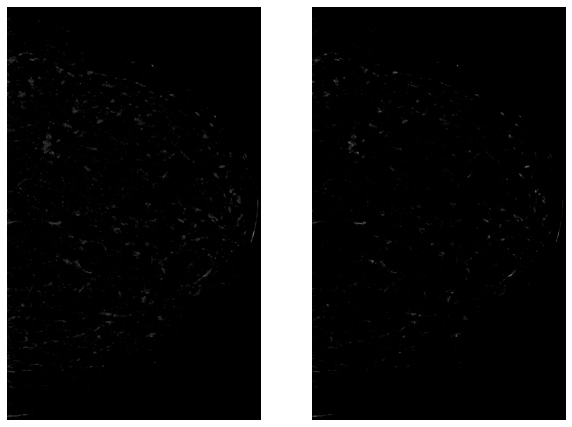

In [22]:
rbd_image_no_bbound_smothed = cv2.GaussianBlur(thr1_rbd, ksize=(3, 3), sigmaX=1)
sobel_rbd = sobel_gradient(rbd_image_no_bbound_smothed)

# rbd_image_no_bbound_uint8 = (255*hd.min_max_norm(rbd_image_no_bbound)).astype(np.uint8)
# sobel_rbd = cv2.Canny(rbd_image_no_bbound_uint8, 100, 100)
simple_im_show2(sobel_rbd, thr1_rbd)

In [23]:
# cv2.imwrite('sobel_rbd.tiff', sobel_rbd)


### Second thresholding and binarizing

In [24]:
quant2 = 0.9999


sobel_rbd_norm = sobel_rbd.copy()
sobel_rbd_norm[sobel_rbd_norm <= sobel_rbd_norm[sobel_rbd_norm!=0].min()] = sobel_rbd_norm[sobel_rbd_norm!=0].min()
sobel_rbd_norm = hd.min_max_norm(sobel_rbd_norm)
simple_im_show2(sobel_rbd_norm, sobel_rbd)


trheshold2 = np.quantile(sobel_rbd_norm[sobel_rbd_norm!=0].ravel(), q=quant2)
print(f'quantile {quant2} - threshold {trheshold2}')

plt.hist(sobel_rbd_norm.ravel(), bins=256)
plt.vlines(trheshold, ymin=0, ymax=3e6, colors='red')
plt.show()



thr2_rbd = sobel_rbd_norm.copy()
thr2_rbd[thr2_rbd <= trheshold2] = 0

simple_im_show2(thr2_rbd, rbd_image_no_bbound)

NameError: name 'hd' is not defined

In [25]:
thr2_rbd_bin = (255*(thr2_rbd>0)).astype(np.uint8)
simple_im_show(thr2_rbd_bin)

NameError: name 'thr2_rbd' is not defined

In [ ]:
# cv2.imwrite('thr2_rbd_bin.tiff', thr2_rbd_bin)


### Geodesic Morphological Reconstruction

In [ ]:
def imreconstruct(marker: np.ndarray, mask: np.ndarray, radius: int = 1):
    """Iteratively expand the markers white keeping them limited by the mask during each iteration.

    :param marker: Grayscale image where initial seed is white on black background.
    :param mask: Grayscale mask where the valid area is white on black background.
    :param radius Can be increased to improve expansion speed while causing decreased isolation from nearby areas.
    :returns A copy of the last expansion.
    Written By Semnodime.
    """
    kernel = np.ones(shape=(radius * 2 + 1,) * 2, dtype=np.uint8)
    if mask.dtype != np.dtype('uint8'):
        mask = (255*hd.min_max_norm(mask)).astype(np.uint8)
    while True:
        expanded = cv2.dilate(src=marker, kernel=kernel)
        cv2.bitwise_and(src1=expanded, src2=mask, dst=expanded)

        # Termination criterion: Expansion didn't change the image at all
        if (marker == expanded).all():
            return expanded
        marker = expanded

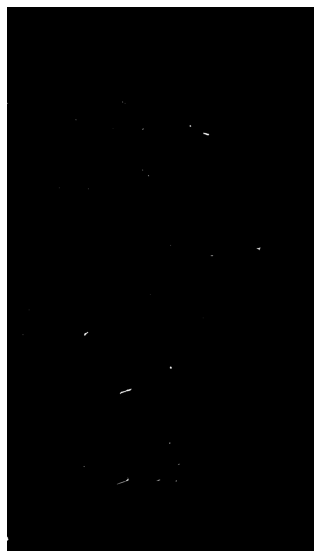

In [ ]:
marker = thr2_rbd_bin.copy()
mask = thr1_rbd

reconstructed_mC = imreconstruct(marker, mask, radius=1)
reconstructed_mC = (255*(reconstructed_mC>0)).astype(np.uint8)

closing_SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
reconstructed_mC_mask = cv2.morphologyEx(reconstructed_mC, cv2.MORPH_CLOSE, closing_SE)
simple_im_show(reconstructed_mC_mask)

In [ ]:
intersected_rois = (reconstructed_mC_mask & image_mask)
components_num, components = cv2.connectedComponents(intersected_rois, connectivity=8)

In [ ]:
pred_mC_num, pred_mC_components = cv2.connectedComponents(reconstructed_mC_mask, connectivity=8)

true_mC_num, true_mC_components = cv2.connectedComponents(image_mask, connectivity=8)

In [ ]:
TP = components_num - 1
FP = pred_mC_num - 1 - TP
FN = true_mC_num - TP

print({'image_id':image_id, 'TP': TP, 'FP': FP, 'FN': FN})

{'image_id': 20586908, 'TP': 17, 'FP': 12, 'FN': 24}


In [ ]:
res_test_img= plot_bboxes_over_image(reconstructed_mC_mask, [true_bboxes], [(0, 255, 0)], ['rect'])
cv2.imwrite('res_test_img.tiff', res_test_img)


True

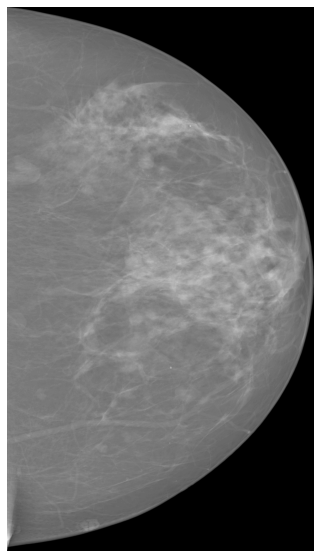

In [ ]:
simple_im_show(image)

### Second Trhesholding on Sobel

quantile 0.95 - threshold 0.1270315870642662


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

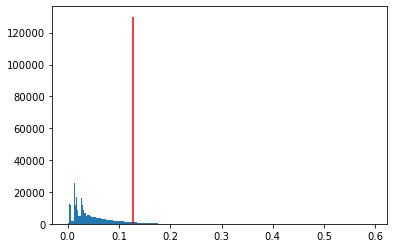

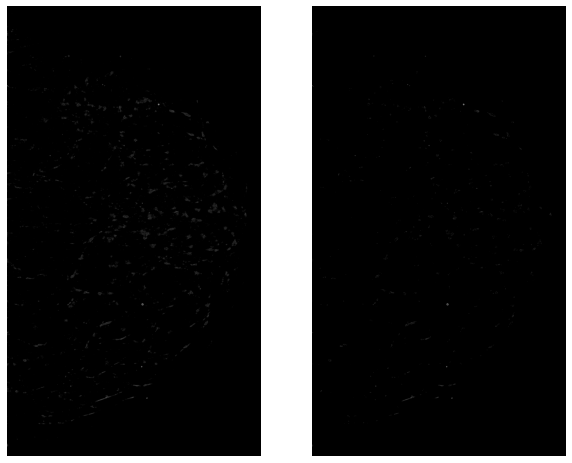

In [22]:
quant2 = 0.95

trheshold2 = np.quantile(sobel_rbd[sobel_rbd!=0].ravel(), q=quant2)
print(f'quantile {quant2} - threshold {trheshold2}')
plt.hist(sobel_rbd[sobel_rbd!=0].ravel(), bins=256)
plt.vlines(trheshold2, ymin=0, ymax=130000, colors='red')
plt.show()


thr2_sobel_rbd = sobel_rbd.copy()
thr2_sobel_rbd[thr2_sobel_rbd <= trheshold2] = 0
# thr2_sobel_rbd = (255*(thr2_sobel_rbd>0)).astype(np.uint8)
simple_im_show2(sobel_rbd, thr2_sobel_rbd)

In [24]:

cv2.imwrite('thr2_sobel_rbd.tiff', thr2_sobel_rbd)


True

### Hough Transform

In [19]:
hough_params = {'method': cv2.HOUGH_GRADIENT,
                 'dp': 1,
                 'minDist': 20,
                 'param1': 300,
                 'param2': 5,
                 'minRadius': 2,
                 'maxRadius': 20}

271


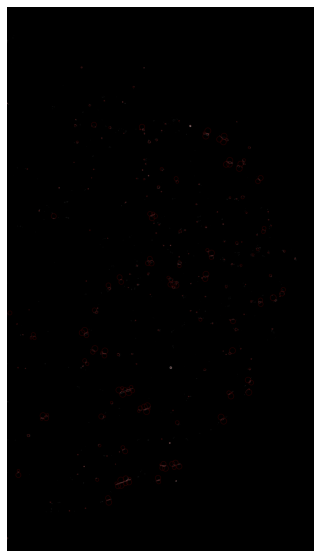

{'image_id': 20586908, 'TP': 17, 'FP': 250, 'FN': 23}

In [23]:
circles = cv2.HoughCircles(to_uint8(thr2_sobel_rbd), **hough_params)[0].astype(int)
print(len(circles))

rbd_image_no_bbound_circles = plot_bboxes_over_image(thr2_sobel_rbd, [circles], [(255, 0, 0)], ['circ'])
simple_im_show(rbd_image_no_bbound_circles)

cv2.imwrite('sobel_rbdcircles.tiff', rbd_image_no_bbound_circles)
TP, FP, FN = quick_circle_comparison(true_bboxes, circles, image_mask)
{'image_id':image_id, 'TP': len(TP), 'FP': FP, 'FN': FN}

### Rolling Ball Extraction

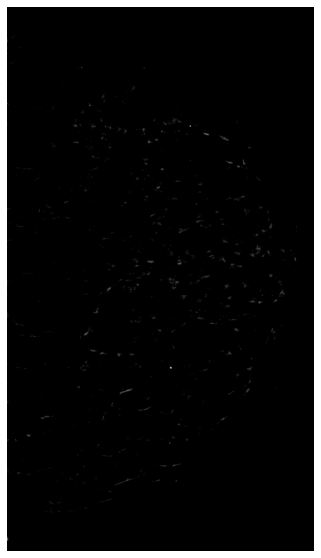

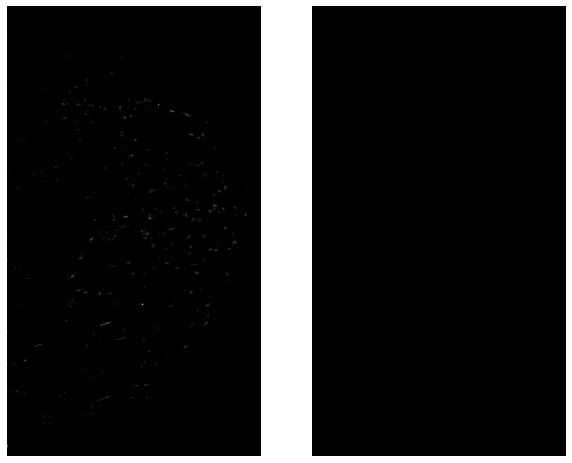

In [31]:
background = restoration.rolling_ball(thr1_rbd, radius=3)
simple_im_show(background)
background_substracted = thr1_rbd - background
simple_im_show2(thr1_rbd, background_substracted)

### Connected Components

In [26]:
from skimage.measure import label

In [27]:
thr1_rbd_bin = to_uint8(255*(thr1_rbd>0))
# ret, markers = cv2.connectedComponents(thr1_rbd_bin, connectivity=4) # RUN ONLY 2 TIMES MAX

markers, ret = label(thr1_rbd_bin, background=0, return_num=True,)

In [28]:
selected_cc = []
# selecting only no wholes candidates
marker_sizes = dict(zip(*np.unique(markers, return_counts=True)))
for marker, msize in tqdm(marker_sizes.items()):
    if  350 > msize >= 2 and marker != 0:
        if msize >=8:
            cc_mask = (markers == marker).astype(np.uint8)
            contours,_ = cv2.findContours(cc_mask, method=cv2.CHAIN_APPROX_NONE, mode=cv2.RETR_EXTERNAL)
            
            contour_mask = cv2.drawContours(np.zeros(markers.shape), contours, -1, 1, -1)
            if not np.all(cc_mask == contour_mask):
                continue
        selected_cc.append(marker)
print(len(selected_cc))
selected_cc_mask = np.isin(markers, selected_cc)

100%|██████████| 12153/12153 [00:11<00:00, 1067.43it/s]


3948


In [29]:
TP_mask = selected_cc_mask & (image_mask>0)
TP = np.unique(image_mask[TP_mask])
print({'TP':len(TP), 'FP':len(selected_cc) - len(TP), 'FN':len(np.unique(image_mask)) - len(TP) - 1})

{'TP': 0, 'FP': 3948, 'FN': 1}


In [30]:
thr1_rbd_selected_cc_masked = thr1_rbd.copy()

thr1_rbd_selected_cc_masked[~selected_cc_mask.astype(bool)] = 0
cv2.imwrite('thr1_rbd_selected_cc_masked.tiff', thr1_rbd_selected_cc_masked)


True

In [87]:
cv2.imwrite('selected_mask_cc.tiff', to_uint8(255*selected_cc_mask))


True

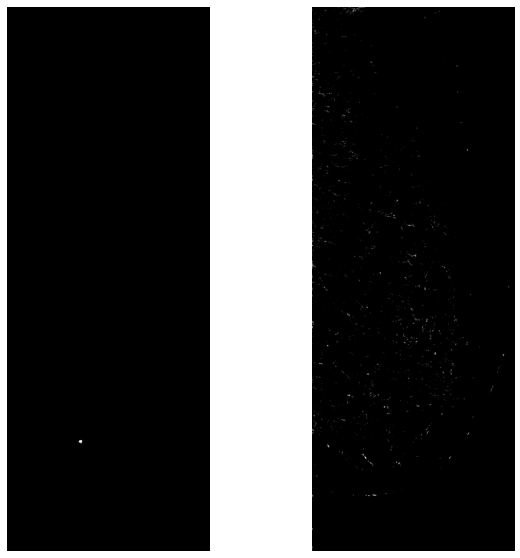

In [88]:
simple_im_show2(image_mask>0, selected_cc_mask)

In [89]:
missdetected_mC = set(image_mask.ravel()).difference(set(image_mask[TP_mask].ravel())).difference(set([0]))
missdetected_mC_mask = np.isin(image_mask, list(missdetected_mC))
cv2.imwrite('missdetected_mC_mask.tiff', 255*missdetected_mC_mask)


True

### CAnny

In [17]:
canny_rbd = cv2.Canny(to_uint8(thr1_rbd), 500, 10)

In [18]:
cv2.imwrite('canny_rbd.tiff', canny_rbd)


True

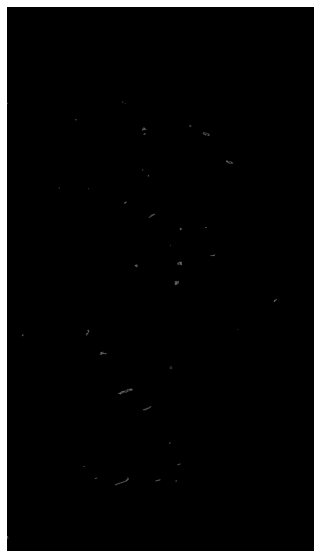

In [19]:
simple_im_show(canny_rbd)